
# HemoVita — Rule-Based Recommendation Engine (v1)

This notebook wires together your **network_relationships.csv** + **Hemovita_Micronutrients.xlsx** with a lean, auditable rule engine that:

1. Loads lab inputs (vitamins, minerals, iron panel).
2. Detects potential deficiencies against configurable reference ranges.
3. Uses the **directed network** (boosts/inhibits) to propose **which supplements to add** and **how to schedule** them to avoid conflicts.
4. Explains recommendations with traceable rules (for transparency).

> **Disclaimer:** Reference ranges and doses here are **placeholders** for engineering/demo purposes. Replace with clinician-approved values before any real use.


In [1]:
from pathlib import Path
import pandas as pd
from typing import Dict, List, Tuple

# running from: hemovita/networks
DATA_DIR = Path.cwd().parent / "cleaned_data"   # ../cleaned_data
XLSX = DATA_DIR / "Hemovita_Micronutrients.xlsx"
EDGES = DATA_DIR / "network_relationships.csv"

print("CWD:", Path.cwd())
print("XLSX exists?", XLSX.exists(), XLSX)
print("EDGES exists?", EDGES.exists(), EDGES)

edges = pd.read_csv(EDGES)
edges.head()


CWD: /Volumes/T7/MAC/COLLEGE/Senior_project_2/model/network
XLSX exists? True /Volumes/T7/MAC/COLLEGE/Senior_project_2/model/cleaned_data/Hemovita_Micronutrients.xlsx
EDGES exists? True /Volumes/T7/MAC/COLLEGE/Senior_project_2/model/cleaned_data/network_relationships.csv


,source,target,effect,confidence,notes
0,vitamin_B12,homocysteine,inhibits,High,B12 re-methylation lowers Hcy
1,folate_plasma,homocysteine,inhibits,High,Folate lowers Hcy
2,vitamin_B6,homocysteine,inhibits,Moderate,B6 supports transsulfuration
3,vitamin_C,vitamin_E,boosts,Moderate-High,Ascorbate recycles α-tocopherol
4,magnesium,vitamin_D,boosts,Moderate,Mg required for D activation/handling


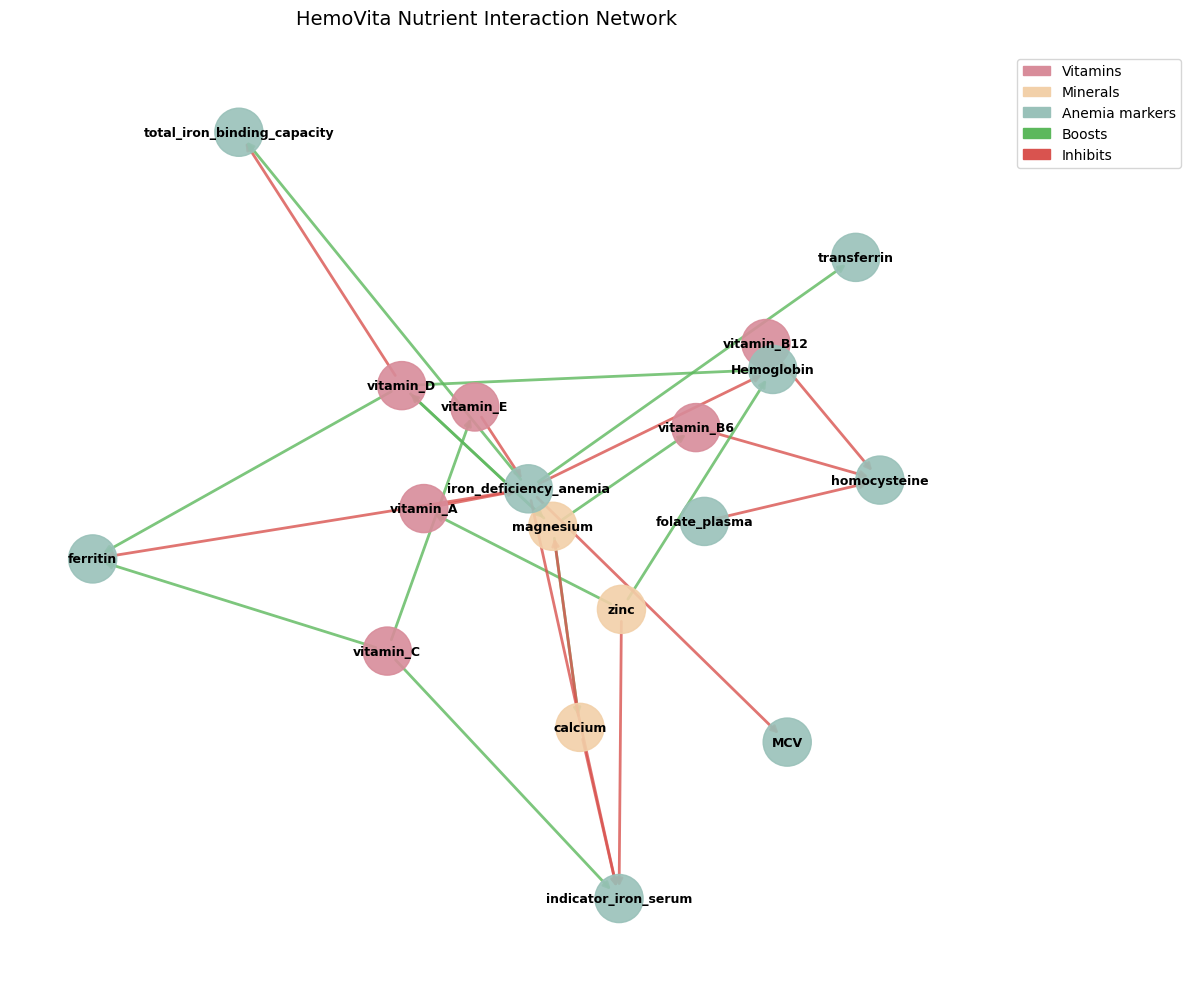

In [3]:
# --- 5) Visualize the complete HemoVita nutrient–biomarker network ---

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load edges
edges = pd.read_csv(EDGES)

# Build directed graph
G = nx.DiGraph()
for _, row in edges.iterrows():
    G.add_edge(
        row["source"], 
        row["target"], 
        effect=row["effect"], 
        confidence=row["confidence"]
    )

# Node styling by category (vitamin, mineral, marker)
vitamins = [n for n in G.nodes if n.startswith("vitamin_")]
minerals = ["calcium","magnesium","zinc"]
biomarkers = [n for n in G.nodes if n not in vitamins + minerals]

color_map = []
for node in G.nodes:
    if node in vitamins:
        color_map.append("#d88c9a")      # soft rose for vitamins
    elif node in minerals:
        color_map.append("#f2d0a9")      # sand for minerals
    else:
        color_map.append("#99c1b9")      # teal for biomarkers / markers

# Edge color by effect
edge_colors = ["#5cb85c" if d["effect"] == "boosts" else "#d9534f" for _,_,d in G.edges(data=True)]

plt.figure(figsize=(12,10))
pos = nx.spring_layout(G, k=0.45, seed=42)

# Draw nodes & edges
nx.draw_networkx_nodes(G, pos, node_color=color_map, node_size=1200, alpha=0.9)
nx.draw_networkx_edges(G, pos, arrows=True, edge_color=edge_colors, width=2, alpha=0.8)
nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold")

# Add legend proxy handles
import matplotlib.patches as mpatches
legend_items = [
    mpatches.Patch(color="#d88c9a", label="Vitamins"),
    mpatches.Patch(color="#f2d0a9", label="Minerals"),
    mpatches.Patch(color="#99c1b9", label="Anemia markers"),
    mpatches.Patch(color="#5cb85c", label="Boosts"),
    mpatches.Patch(color="#d9534f", label="Inhibits"),
]
plt.legend(handles=legend_items, loc="upper left", bbox_to_anchor=(1.05, 1.0))
plt.title("HemoVita Nutrient Interaction Network", fontsize=14, pad=20)
plt.axis("off")
plt.tight_layout()
plt.show()


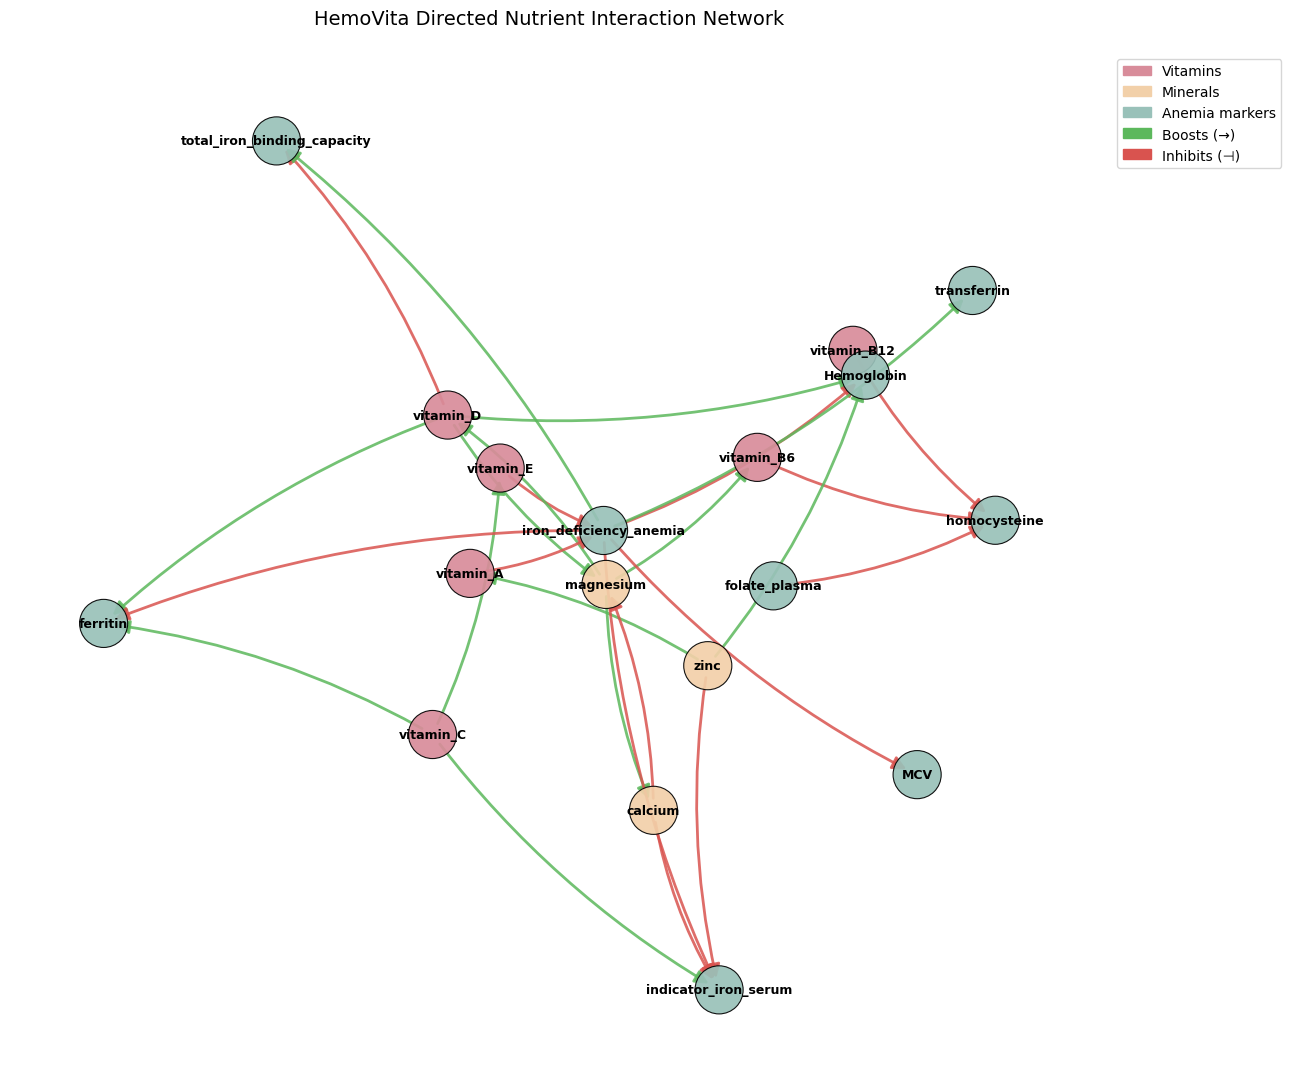

In [4]:
# --- Directed network visualization (with visible arrowheads) ---

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load edges
edges = pd.read_csv(EDGES)

# Build directed graph
G = nx.DiGraph()
for _, row in edges.iterrows():
    G.add_edge(
        row["source"],
        row["target"],
        effect=row["effect"],
        confidence=row["confidence"]
    )

# Categorize nodes
vitamins = [n for n in G.nodes if n.startswith("vitamin_")]
minerals = ["calcium", "magnesium", "zinc"]
biomarkers = [n for n in G.nodes if n not in vitamins + minerals]

# Assign colors
color_map = []
for node in G.nodes:
    if node in vitamins:
        color_map.append("#d88c9a")  # rose
    elif node in minerals:
        color_map.append("#f2d0a9")  # beige
    else:
        color_map.append("#99c1b9")  # teal

# Edge colors by effect type
edge_colors = [
    "#5cb85c" if d["effect"].lower() == "boosts" else "#d9534f"
    for _, _, d in G.edges(data=True)
]

# Layout
plt.figure(figsize=(13, 11))
pos = nx.spring_layout(G, k=0.5, seed=42)

# Draw nodes
nx.draw_networkx_nodes(
    G, pos,
    node_color=color_map,
    node_size=1200,
    alpha=0.92,
    linewidths=0.8,
    edgecolors="black"
)

# Draw edges with arrowheads
nx.draw_networkx_edges(
    G, pos,
    arrowstyle='-|>',     # sharp arrow
    arrowsize=20,         # larger arrowheads
    width=2,
    edge_color=edge_colors,
    connectionstyle="arc3,rad=0.1",
    alpha=0.85
)

# Labels
nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold")

# Legend
legend_items = [
    mpatches.Patch(color="#d88c9a", label="Vitamins"),
    mpatches.Patch(color="#f2d0a9", label="Minerals"),
    mpatches.Patch(color="#99c1b9", label="Anemia markers"),
    mpatches.Patch(color="#5cb85c", label="Boosts (→)"),
    mpatches.Patch(color="#d9534f", label="Inhibits (⊣)"),
]
plt.legend(handles=legend_items, loc="upper left", bbox_to_anchor=(1.02, 1.0))

plt.title("HemoVita Directed Nutrient Interaction Network", fontsize=14, pad=20)
plt.axis("off")
plt.tight_layout()
plt.show()


In [12]:

# Pull sheet names (node universe) to validate labels
xls = pd.ExcelFile(XLSX)
sheets = xls.sheet_names
print("Sheets:", sheets)
missing = set(edges['source']).union(edges['target']) - set(sheets)
print("Unknown nodes in edges (should be empty):", missing)


Sheets: ['vitamin_A', 'vitamin_B6', 'vitamin_B12', 'vitamin_C', 'vitamin_D', 'vitamin_E', 'calcium', 'magnesium', 'zinc', 'transferrin', 'total_iron_binding_capacity', 'indicator_iron_serum', 'ferritin', 'body_iron_stores', 'homocysteine', 'folate_rbc', 'folate_plasma', 'Hemoglobin', 'iron_deficiency_anemia', 'MCV']
Unknown nodes in edges (should be empty): set()



## 1) Reference ranges (PLACEHOLDERS — replace with vetted ranges)

These are **not medical guidance**. They simply allow the engine to flag low / borderline values.


In [17]:
import pandas as pd

file_path = "../cleaned_data/Hemovita_Micronutrients.xlsx"
vitamin_d = pd.read_excel(file_path, sheet_name="vitamin_D")
ferritin = pd.read_excel(file_path, sheet_name="ferritin")

# Evaluate based on reference range
vitamin_d["Flag"] = vitamin_d.apply(
    lambda row: "Low" if row["Value"] < row["Reference_Min"] else
                "High" if row["Value"] > row["Reference_Max"] else
                "Normal",
    axis=1
)


KeyError: 'Value'

In [16]:

# Minimal reference ranges (placeholder). Customize per lab units in your data.
REF = {
    'Hemoglobin': {'low': 12.0, 'high': 16.0},   # g/dL (sex-specific in practice)
    'MCV': {'low': 80, 'high': 100},             # fL
    'ferritin': {'low': 30, 'high': 200},        # ng/mL (context/sex-specific)
    'indicator_iron_serum': {'low': 60, 'high': 170}, # ug/dL (lab-specific)
    'transferrin': {'low': 200, 'high': 360},    # mg/dL
    'total_iron_binding_capacity': {'low': 250, 'high': 450}, # ug/dL
    'vitamin_B12': {'low': 200, 'high': 900},    # pg/mL
    'folate_plasma': {'low': 4.0, 'high': 20.0}, # ng/mL
    'vitamin_D': {'low': 20, 'high': 50},        # ng/mL (25(OH)D)
    'vitamin_C': {'low': 0.4, 'high': 2.0},      # mg/dL (example)
    'vitamin_E': {'low': 5.0, 'high': 20.0},     # mg/L (example)
    'vitamin_A': {'low': 20, 'high': 80},        # ug/dL (example)
    'vitamin_B6': {'low': 5, 'high': 50},        # ug/L (example; highly lab-specific)
    'magnesium': {'low': 1.7, 'high': 2.3},      # mg/dL
    'calcium': {'low': 8.6, 'high': 10.2},       # mg/dL
    'zinc': {'low': 60, 'high': 120},            # ug/dL (plasma)
    'homocysteine': {'low': 5, 'high': 15},      # umol/L
}

def classify_value(marker: str, value: float) -> str:
    rng = REF.get(marker)
    if not rng or value is None:
        return "unknown"
    if value < rng['low']:
        return "low"
    if value > rng['high']:
        return "high"
    return "normal"


In [8]:
from pathlib import Path
import pandas as pd
import re
from typing import Optional, Tuple, Dict, Any

XLSX = Path("../cleaned_data/Hemovita_Micronutrients.xlsx")  # adjust path if needed

# --- 1) Robust numeric parsing helpers ---------------------------------------

_num_re = re.compile(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?")

def parse_numeric_cell(val) -> Optional[float]:
    """
    Extract a single float from a messy cell like '≤ 30 ng/mL', '30–50', '>=15', 'about 12'.
    If it finds a range 'a-b', it returns the first number (lower bound) by design.
    Returns None if no number found.
    """
    if val is None or (isinstance(val, float) and pd.isna(val)):
        return None
    s = str(val).strip()
    m = _num_re.findall(s.replace("–", "-").replace("—", "-"))
    if not m:
        return None
    # if it's a range like '30-50', keep the first number by default
    try:
        return float(m[0])
    except ValueError:
        return None

def pick_cutoff(series: pd.Series) -> Optional[float]:
    """
    Given a series (column) that may contain a mix of numbers/strings,
    pick the first valid numeric cutoff (scanning top -> bottom).
    """
    if series is None:
        return None
    for v in series:
        x = parse_numeric_cell(v)
        if x is not None:
            return x
    return None

# --- 2) Map your sheets -> cutoff column names (exact names you supplied) -----

CUTOFF_MAP: Dict[str, Dict[str, str]] = {
    "vitamin_A": {
        "deficiency_low": "Vitamin A deficiency cut-off",
        "marginal_low": "Marginal vitamin A deficiency cut-off",
        "severe_low": "Severe vitamin A deficiency cut-off",
    },
    "vitamin_B6": {
        "deficiency_low": "Deficiency cut-off",
        "marginal_low": "Marginal cut-off",
    },
    "vitamin_B12": {
        "deficiency_low": "Deficiency cut-off",
        "insuff_low": "Insufficiency cut-off",
    },
    "vitamin_C": {
        "deficiency_low": "Low vitamin C cut-off",
    },
    "vitamin_D": {
        "deficiency_low": "Deficiency cut-off",
        "insuff_low": "Insufficiency cut-off",
    },
    "vitamin_E": {
        "deficiency_low": "Deficiency cut-off",
        "marginal_low": "Marginal deficiency cut-off",
    },
    "calcium": {
        "deficiency_low": "Deficiency cut-off",
    },
    "magnesium": {
        "deficiency_low": "Deficiency cut-off",
        "low_low": "Low cut-off",  # slightly higher threshold than 'deficiency'
    },
    "zinc": {
        "deficiency_low": "Deficiency cut-off",
    },
    "transferrin": {
        "low_low": "Low cut-off",
    },
    "total_iron_binding_capacity": {
        "low_low": "Low cut-off",
        "elevated_high": "Elevated threshold",
    },
    "indicator_iron_serum": {
        "deficiency_low": "Low iron cut-off",
        "marginal_low": "Marginal iron cut-off",
    },
    "ferritin": {
        "deficiency_low": "Deficiency cut-off",
    },
    "homocysteine": {
        "elevated_high": "Elevated threshold",
        "mildly_high": "Mildly elevated threshold",
    },
    "folate_plasma": {
        # You wrote "IDA cut-off" here; we will still treat it as a low-side folate threshold.
        "deficiency_low": "IDA cut-off",
    },
    "Hemoglobin": {
        "deficiency_low": "IDA cut-off",
    },
    "iron_deficiency_anemia": {
        # This is a diagnosis sheet; if present, we'll just read the threshold but
        # usually you derive IDA from Hb + ferritin; leave here for completeness.
        "deficiency_low": "IDA cut-off",
    },
    "MCV": {
        "micro_low": "Microcytic anaemia cut-off",   # low-side threshold
        "macro_high": "Macrocytic anaemia cut-off",  # high-side threshold
    },
}

# --- 3) Load workbook, extract thresholds into REF and REF_TIERS --------------

xls = pd.ExcelFile(XLSX)

REF_FALLBACK = {  # keep your previous placeholders as fallback only
    'Hemoglobin': {'low': 12.0, 'high': 16.0},
    'MCV': {'low': 80, 'high': 100},
    'ferritin': {'low': 30, 'high': 200},
    'indicator_iron_serum': {'low': 60, 'high': 170},
    'transferrin': {'low': 200, 'high': 360},
    'total_iron_binding_capacity': {'low': 250, 'high': 450},
    'vitamin_B12': {'low': 200, 'high': 900},
    'folate_plasma': {'low': 4.0, 'high': 20.0},
    'vitamin_D': {'low': 20, 'high': 50},
    'vitamin_C': {'low': 0.4, 'high': 2.0},
    'vitamin_E': {'low': 5.0, 'high': 20.0},
    'vitamin_A': {'low': 20, 'high': 80},
    'vitamin_B6': {'low': 5, 'high': 50},
    'magnesium': {'low': 1.7, 'high': 2.3},
    'calcium': {'low': 8.6, 'high': 10.2},
    'zinc': {'low': 60, 'high': 120},
    'homocysteine': {'low': 5, 'high': 15},
}

REF: Dict[str, Dict[str, float]] = {}
REF_TIERS: Dict[str, Dict[str, float]] = {}  # richer, optional

def load_sheet_cutoffs(sheet: str) -> Dict[str, float]:
    """Read one sheet; pull the numeric from each mapped cutoff column."""
    if sheet not in xls.sheet_names:
        return {}
    df = xls.parse(sheet)
    # normalize headers to allow minor inconsistencies
    norm_cols = {c: str(c).strip() for c in df.columns}
    df.rename(columns=norm_cols, inplace=True)
    out = {}
    for tier_key, col_name in CUTOFF_MAP.get(sheet, {}).items():
        if col_name in df.columns:
            val = pick_cutoff(df[col_name])
            if val is not None:
                out[tier_key] = float(val)
    return out

# Build REF (simple low/high) + REF_TIERS (detailed) from workbook
for sheet in CUTOFF_MAP.keys():
    tiers = load_sheet_cutoffs(sheet)
    REF_TIERS[sheet] = tiers  # store all we found (may be empty)

    # SIMPLE REF mapping rules:
    low = None
    high = None

    # prioritize specific keys
    # low side preference order
    for k in ["deficiency_low", "micro_low", "low_low", "marginal_low", "insuff_low", "severe_low"]:
        if tiers.get(k) is not None:
            low = tiers[k]; break

    # high side preference order
    for k in ["macro_high", "elevated_high", "mildly_high"]:
        if tiers.get(k) is not None:
            high = tiers[k]; break

    # Special cases:
    # - Homocysteine has only high-side thresholds; keep only 'high' if present.
    # - Some sheets (e.g., MCV) have both low and high (micro/macro).

    if low is not None or high is not None:
        REF[sheet] = {}
        if low is not None:  REF[sheet]["low"]  = low
        if high is not None: REF[sheet]["high"] = high

# Merge fallback for anything still missing
for k, v in REF_FALLBACK.items():
    REF.setdefault(k, v)

print("Built REF from workbook. Example entries:")
for i, (k, v) in enumerate(REF.items()):
    print(f"  {k}: {v}")
    if i >= 8: break

# --- 4) Your existing classifier now uses dynamic REF -------------------------

def classify_value(marker: str, value: float) -> str:
    rng = REF.get(marker)
    if not rng or value is None or pd.isna(value):
        return "unknown"
    if "low" in rng and value < rng["low"]:
        # allow nuanced labels via REF_TIERS if you want:
        # e.g., if value < severe_low (when present), return "severe_low"
        tiers = REF_TIERS.get(marker, {})
        sev = tiers.get("severe_low")
        marg = tiers.get("marginal_low") or tiers.get("insuff_low") or tiers.get("low_low")
        if sev is not None and value < sev:
            return "severe_low"
        if marg is not None and value < rng["low"]:
            return "low"  # keep simple output; you can return "marginal_low" if desired
        return "low"
    if "high" in rng and value > rng["high"]:
        tiers = REF_TIERS.get(marker, {})
        mild = tiers.get("mildly_high")
        if mild is not None and value > mild:
            return "high"  # again, you could return "mildly_high" for nuance
        return "high"
    return "normal"


Built REF from workbook. Example entries:
  vitamin_A: {'low': 0.7}
  vitamin_B6: {'low': 20.0}
  vitamin_B12: {'low': 145.0}
  vitamin_C: {'low': 11.0}
  vitamin_D: {'low': 30.0}
  vitamin_E: {'low': 11.63}
  calcium: {'low': 8.5}
  magnesium: {'low': 0.62}
  zinc: {'low': 11.3}



## 2) Conflict-aware scheduling rules

- **Iron** prefers **AM (empty)** with **Vitamin C**.  
- Keep **Calcium/Zinc** **2–4 hours away** from **Iron**.  
- **Magnesium** supports **Vitamin D** activation; place with main meal or PM.  
- **B12 before Folate** when both are low (sequence rule).  


In [9]:

# Define time slots and antagonists for simple scheduling
SLOTS = ["AM_empty", "MID_with_food", "PM_with_food"]

ANTAGONISTS = {
    # Taking these together is discouraged
    'iron_bundle': {'iron_like': ['indicator_iron_serum', 'ferritin'], 'avoid_with': ['calcium', 'zinc']}
}

BOOSTERS = {
    # Co-dose boosts
    'iron': ['vitamin_C'],
    'vitamin_D': ['magnesium'],  # Mg enables D activation
}

PRIORITY = [
    # Higher priority addressed earlier
    'ferritin', 'indicator_iron_serum', 'Hemoglobin', 'MCV',
    'vitamin_B12', 'folate_plasma', 'vitamin_D', 'magnesium',
    'zinc', 'calcium', 'vitamin_C', 'vitamin_A', 'vitamin_E', 'vitamin_B6', 'homocysteine'
]

def rank_targets(labs: Dict[str, float]) -> List[str]:
    # rank by severity (z-ish) fallback to PRIORITY order
    def severity_score(m):
        val = labs.get(m)
        ref = REF.get(m)
        if not ref or val is None:
            return 0.0
        if val < ref['low']:
            return (ref['low'] - val) / max(1e-6, ref['low'])
        if val > ref['high']:
            return (val - ref['high']) / max(1e-6, ref['high'])
        return 0.0
    scored = sorted(PRIORITY, key=lambda m: (-severity_score(m), PRIORITY.index(m) if m in PRIORITY else 999))
    return [m for m in scored if severity_score(m) > 0]


In [10]:

def schedule_recommendations(deficits: List[str]) -> dict:
    plan = {slot: [] for slot in SLOTS}

    def can_place(nutrient: str, slot: str) -> bool:
        if nutrient in ['indicator_iron_serum', 'ferritin']:
            # treat as "iron supplementation" proxy for scheduling
            avoid = set(ANTAGONISTS['iron_bundle']['avoid_with'])
            for already in plan[slot]:
                if already in avoid:
                    return False
        if nutrient in ['zinc', 'calcium']:
            # don't schedule Zn/Ca with iron proxies
            iron_like = set(ANTAGONISTS['iron_bundle']['iron_like'])
            for already in plan[slot]:
                if already in iron_like:
                    return False
        return True

    for m in deficits:
        placed = False
        # Preferred slots
        preferred = []
        if m in ['indicator_iron_serum', 'ferritin']:
            preferred = ["AM_empty", "MID_with_food", "PM_with_food"]
        elif m in ['zinc']:
            preferred = ["MID_with_food"]
        elif m in ['calcium']:
            preferred = ["PM_with_food"]
        elif m in ['vitamin_D', 'magnesium']:
            preferred = ["MID_with_food", "PM_with_food"]
        else:
            preferred = SLOTS

        for slot in preferred:
            if can_place(m, slot):
                plan[slot].append(m)
                placed = True
                break
        if not placed:
            # fallback: place wherever with least conflicts
            best = min(SLOTS, key=lambda s: len(plan[s]))
            plan[best].append(m)

    # Add boosters (e.g., place vitamin C with iron if iron scheduled in AM)
    for slot, items in plan.items():
        if any(k in items for k in ['indicator_iron_serum', 'ferritin']):
            if 'vitamin_C' not in items:
                items.append('vitamin_C')
        if 'vitamin_D' in items and 'magnesium' not in items:
            items.append('magnesium')

    return plan



## 3) End-to-end: from lab values → labeled deficits → schedule + explanations


In [19]:

def detect_deficits(labs: Dict[str, float]) -> Dict[str, str]:
    labels = {}
    for marker, val in labs.items():
        labels[marker] = classify_value(marker, val)
    return labels

def pick_targets(deficit_labels: Dict[str, str]) -> List[str]:
    # Choose only "low" for supplementation; high values may imply reduce/avoid but not implemented here
    return [m for m, lab in deficit_labels.items() if lab == 'low']

def explain_recommendations(plan: dict) -> Dict[str, List[str]]:
    notes = {}
    for slot, items in plan.items():
        slot_notes = []
        if 'indicator_iron_serum' in items or 'ferritin' in items:
            slot_notes.append("Co-dose Vitamin C with iron; keep calcium/zinc 2–4h away.")
        if 'vitamin_D' in items:
            slot_notes.append("Magnesium supports Vitamin D activation; keep them together if tolerated.")
        if 'vitamin_B12' in items and 'folate_plasma' in items:
            slot_notes.append("If both low: initiate B12 before/with folate to avoid masking neurological issues.")
        notes[slot] = slot_notes
    return notes

# Demo inputs (synthetic). Replace with real values pulled from your sheets.
sample_labs = {
    'Hemoglobin': 11.4,
    'MCV': 78,
    'ferritin': 12,
    'indicator_iron_serum': 45,
    'transferrin': 380,
    'total_iron_binding_capacity': 430,
    'vitamin_B12': 230,
    'folate_plasma': 3.2,
    'vitamin_D': 18,
    'magnesium': 1.6,
    'zinc': 58,
    'calcium': 8.8,
    'vitamin_C': 0.5,
    'vitamin_A': 28,
    'vitamin_E': 5.5,
    'vitamin_B6': 4.9,
    'homocysteine': 18,
}

labels = detect_deficits(sample_labs)
targets = pick_targets(labels)
ranked = rank_targets(sample_labs)
plan = schedule_recommendations(ranked)
notes = explain_recommendations(plan)

labels, ranked, plan, notes


({'Hemoglobin': 'low',
  'MCV': 'low',
  'ferritin': 'low',
  'indicator_iron_serum': 'low',
  'transferrin': 'high',
  'total_iron_binding_capacity': 'normal',
  'vitamin_B12': 'normal',
  'folate_plasma': 'low',
  'vitamin_D': 'low',
  'magnesium': 'low',
  'zinc': 'low',
  'calcium': 'normal',
  'vitamin_C': 'normal',
  'vitamin_A': 'normal',
  'vitamin_E': 'normal',
  'vitamin_B6': 'low',
  'homocysteine': 'high'},
 ['ferritin',
  'indicator_iron_serum',
  'homocysteine',
  'folate_plasma',
  'vitamin_D',
  'magnesium',
  'Hemoglobin',
  'zinc',
  'MCV',
  'vitamin_B6'],
 {'AM_empty': ['ferritin',
   'indicator_iron_serum',
   'homocysteine',
   'folate_plasma',
   'Hemoglobin',
   'MCV',
   'vitamin_B6',
   'vitamin_C'],
  'MID_with_food': ['vitamin_D', 'magnesium', 'zinc'],
  'PM_with_food': []},
 {'AM_empty': ['Co-dose Vitamin C with iron; keep calcium/zinc 2–4h away.'],
  'MID_with_food': ['Magnesium supports Vitamin D activation; keep them together if tolerated.'],
  'PM_with_

# food reccomendation

In [11]:
foods = pd.read_csv('/Volumes/T7/MAC/COLLEGE/Senior_project_2/model/cleaned_data/food1.csv')

In [12]:
VIT_A_COL = ("Data.Vitamins.Vitamin A - RAE"
             if "Data.Vitamins.Vitamin A - RAE" in foods.columns
             else ("Data.Vitamins.Vitamin A - IU"
                   if "Data.Vitamins.Vitamin A - IU" in foods.columns
                   else None))

# Columns available for recs (this file does NOT include Vitamin D / Folate nutrient columns)
NUTRIENT_COL = {
    "iron":        "Data.Major Minerals.Iron",
    "zinc":        "Data.Major Minerals.Zinc",
    "magnesium":   "Data.Major Minerals.Magnesium",
    "calcium":     "Data.Major Minerals.Calcium",
    "vitamin_c":   "Data.Vitamins.Vitamin C",
    "vitamin_e":   "Data.Vitamins.Vitamin E",
    "vitamin_b6":  "Data.Vitamins.Vitamin B6",
    "vitamin_b12": "Data.Vitamins.Vitamin B12",
    "vitamin_a":   VIT_A_COL,
    # "vitamin_d":   (not in dataset)
    # "folate":      (not in dataset)
}
# Keep only columns that actually exist
NUTRIENT_COL = {k: v for k, v in NUTRIENT_COL.items() if v and v in foods.columns}

# Anemia markers ⇒ recommend iron foods
ANEMIA_MARKERS = {
    'total_iron_binding_capacity',
    'ferritin',
    'transferrin',
    'hemoglobin',
    'iron_deficiency_anemia',
    'folate_plasma',
    'homocysteine',
    'mcv',
    'indicator_iron_serum',
}

# Map lab markers → nutrient category for foods
MARKER_TO_NUTRIENT = {
    **{m: "iron" for m in ANEMIA_MARKERS},  # your rule
    # vitamins/minerals that are in this dataset
    "vitamin_b12": "vitamin_b12",
    "zinc": "zinc",
    "magnesium": "magnesium",
    "calcium": "calcium",
    "vitamin_c": "vitamin_c",
    "vitamin_a": "vitamin_a",
    "vitamin_e": "vitamin_e",
    "vitamin_b6": "vitamin_b6",
    # NOTE: vitamin_d and folate are not present as columns in food1.csv
}

# Base columns we’ll show with each recommendation row
BASE_FOOD_COLS = ["Category", "Description", "Nutrient Data Bank Number", "Data.Kilocalories"]

In [13]:
def _num(s):
    """Safe numeric coercion."""
    return pd.to_numeric(s, errors="coerce")

def _with_numeric(foods_df: pd.DataFrame, nutrient_col: str) -> pd.DataFrame:
    """Attach per-100g and per-100kcal nutrient metrics."""
    df = foods_df[BASE_FOOD_COLS + [nutrient_col]].copy()
    df[nutrient_col] = _num(df[nutrient_col])              # raw value per 100g (dataset convention)
    kcal = _num(df["Data.Kilocalories"]).replace(0, np.nan)
    df["per100g"] = df[nutrient_col]
    df["per100kcal"] = df[nutrient_col] / (kcal / 100.0)   # nutrient density
    return df

def top_foods_for_nutrient(foods_df: pd.DataFrame, nutrient_col: str, top_n: int = 12):
    """Return top foods by absolute per-100g and per-100kcal density for a nutrient column."""
    df = _with_numeric(foods_df, nutrient_col)
    abs_top = df.dropna(subset=["per100g"]).sort_values("per100g", ascending=False).head(top_n)
    dens_top = df.dropna(subset=["per100kcal"]).sort_values("per100kcal", ascending=False).head(top_n)
    return abs_top, dens_top

In [ ]:

# from IPython.display import display

# TOP_N = 5        # set to 3–5 as you like
# SERVING_G = 100  # change to e.g. 150 to also show per 150 g

# def _to_nutrient(item: str):
#     # MARKER_TO_NUTRIENT should have lowercase keys
#     return MARKER_TO_NUTRIENT.get(item.lower())

# def concise_top_foods_for_nutrient(foods_df: pd.DataFrame, nutrient_key: str) -> pd.DataFrame | None:
#     """Return a compact top-N table (per 100 g) with optional per-serving column."""
#     col = NUTRIENT_COL.get(nutrient_key)
#     if not col:
#         return None

#     df = _with_numeric(foods_df, col)  # adds per100g and per100kcal
#     out = (
#         df.sort_values("per100g", ascending=False)
#           .head(TOP_N)
#           .loc[:, ["Description", "Category", "Data.Kilocalories", "per100g"]]
#           .copy()
#     )
#     # Optional per-serving
#     if SERVING_G and SERVING_G != 100:
#         out[f"per {SERVING_G} g"] = out["per100g"] * (SERVING_G / 100.0)

#     # Prettify column names
#     nice = nutrient_key.replace("_", " ").title()
#     out = out.rename(columns={
#         "Data.Kilocalories": "kcal (per 100 g)",
#         "per100g": f"{nice} (per 100 g)"
#     })
#     return out.reset_index(drop=True)

# # Build nutrient sets from the actual supplement 'plan' (AM/MID/PM)
# slot_to_nutrients = {slot: set() for slot in plan}
# for slot, items in plan.items():
#     for it in items:
#         nk = _to_nutrient(it)
#         if nk:
#             slot_to_nutrients[slot].add(nk)

# # Generate concise tables per slot, showing only 3–5 top foods per nutrient (per 100 g)
# slot_food_recs = {}
# for slot, nutrients in slot_to_nutrients.items():
#     print(f"\n=== {slot}: Top foods (per 100 g) for scheduled items ===")
#     if not nutrients:
#         print("  (no nutrient-backed foods for this slot)")
#         continue

#     slot_food_recs[slot] = {}
#     for nk in sorted(nutrients):
#         tbl = concise_top_foods_for_nutrient(foods, nk)
#         if tbl is None:
#             # e.g., vitamin_d / folate not present in food1.csv
#             print(f"  • {nk}: No '{nk}' column in foods dataset.")
#             slot_food_recs[slot][nk] = {"available": False, "reason": f"No '{nk}' column in foods dataset."}
#             continue

#         print(f"\n  • {nk.replace('_',' ').title()}")
#         display(tbl)
#         slot_food_recs[slot][nk] = {"available": True, "table": tbl}


=== AM_empty: Top foods (per 100 g) for scheduled items ===

  • Iron


,Description,Category,kcal (per 100 g),Iron (per 100 g)
0,"SPICES,THYME,DRIED",SPICES,276,123.60
1,"PARSLEY,DRIED",PARSLEY,276,97.86
2,"SPEARMINT,DRIED",SPEARMINT,285,87.47
3,"MARJORAM,DRIED",MARJORAM,271,82.71
4,"WHALE,BELUGA,MEAT,DRIED (ALASKA NATIVE)",WHALE,327,72.35



  • Vitamin B6


,Description,Category,kcal (per 100 g),Vitamin B6 (per 100 g)
0,"CEREALS RTE,KELLOGG,KELLOGG'S ALL-BRAN ORIGINAL",CEREALS RTE,260,12.00
1,"CEREALS RTE,MALT-O-MEAL,HI FIBER BRAN FLAKES",CEREALS RTE,388,9.68
2,"CEREALS RTE,KELLOGG,KELLOGG'S ALL-BRAN W/ EX F...",CEREALS RTE,192,8.00
3,"FRUIT-FLAVORED DRK,PDR,W/ HI VIT C W/ OTHER AD...",FRUIT-FLAVORED DRK,227,8.00
4,"ORANGE-FLAVOR DRK,BRKFST TYPE,LO CAL,PDR",ORANGE-FLAVOR DRK,217,8.00



  • Vitamin C


,Description,Category,kcal (per 100 g),Vitamin C (per 100 g)
0,"ORANGE-FLAVOR DRK,BRKFST TYPE,LO CAL,PDR",ORANGE-FLAVOR DRK,217,2400.0
1,"FRUIT-FLAVORED DRK,PDR,W/ HI VIT C W/ OTHER AD...",FRUIT-FLAVORED DRK,227,2400.0
2,"PEPPERS,SWT,GRN,FREEZE-DRIED",PEPPERS,314,1900.0
3,"PEPPERS,SWT,RED,FREEZE-DRIED",PEPPERS,314,1900.0
4,"ACEROLA,(WEST INDIAN CHERRY),RAW",ACEROLA,32,1677.6



=== MID_with_food: Top foods (per 100 g) for scheduled items ===

  • Magnesium


,Description,Category,kcal (per 100 g),Magnesium (per 100 g)
0,"RICE BRAN,CRUDE",RICE BRAN,316,781
1,"SEAWEED,AGAR,DRIED",SEAWEED,306,770
2,"COTTONSEED MEAL,PART DEFATTED (GLANDLESS)",COTTONSEED MEAL,367,760
3,"COTTONSEED FLR,PART DEFATTED (GLANDLESS)",COTTONSEED FLR,359,721
4,"COTTONSEED FLR,LOFAT (GLANDLESS)",COTTONSEED FLR,332,716



  • Zinc


,Description,Category,kcal (per 100 g),Zinc (per 100 g)
0,"OYSTER,EASTERN,WILD,CKD,MOIST HEAT",OYSTER,137,181.61
1,"OYSTER,EASTERN,CANNED",OYSTER,69,90.95
2,"OYSTER,EASTERN,WILD,RAW",OYSTER,68,90.81
3,"OYSTER,EASTERN,CKD,BREADED&FRIED",OYSTER,197,87.13
4,"OYSTER,EASTERN,WILD,CKD,DRY HEAT",OYSTER,72,73.60



=== PM_with_food: Top foods (per 100 g) for scheduled items ===
  (no nutrient-backed foods for this slot)


In [27]:

from IPython.display import display

TOP_N = 5        # set to 3–5 as you like
SERVING_G = 100  # change to e.g. 150 to also show per 150 g

def _to_nutrient(item: str):
    # MARKER_TO_NUTRIENT should have lowercase keys
    return MARKER_TO_NUTRIENT.get(item.lower())

_BASE_STOPWORDS = {
    "raw","cooked","boiled","baked","grilled","roasted","broiled","steamed","fried","sauteed","smoked",
    "canned","drained","pickled","breaded","braised","stewed","pan","pan-broiled","ns","nfs","unspecified",
    "with","without","salt","added","no","lean","only","skinless","boneless","refuse","dry","instant",
    "prepared","restaurant","fast","foods","babyfood","mix","frozen","fresh"
}

def _normalize_base_food(desc: str) -> str:
    """Turn 'OYSTERS, EASTERN, COOKED, BREADED' -> 'oyster' (a base identity)."""
    if not isinstance(desc, str):
        return ""
    # Keep only the part before the first comma (often the core item)
    core = desc.split(",")[0]
    # strip parentheses content and punctuation
    core = re.sub(r"\(.*?\)", "", core)
    core = re.sub(r"[^A-Za-z\s&]", " ", core)
    core = core.lower().replace("&", " and ").strip()
    # tokenize, drop stopwords, naive singularize
    tokens = []
    for t in core.split():
        if t in _BASE_STOPWORDS:
            continue
        # naive singularization
        if len(t) > 3 and t.endswith("es"):
            t = t[:-2]
        elif len(t) > 3 and t.endswith("s"):
            t = t[:-1]
        tokens.append(t)
    base = " ".join(tokens).strip()
    # fallback to the first token if we stripped everything
    if not base and isinstance(desc, str) and len(desc.split(",")) > 0:
        base = desc.split(",")[0].strip().lower()
    return base

def concise_top_foods_for_nutrient(foods_df: pd.DataFrame, nutrient_key: str) -> pd.DataFrame | None:
    """
    Return a compact, de-duplicated top-N table (per 100 g), ensuring variety:
    multiple variants of the same base food collapse to one best entry.
    """
    col = NUTRIENT_COL.get(nutrient_key)
    if not col:
        return None

    df = _with_numeric(foods_df, col)  # adds per100g, per100kcal
    # Create a "base food" key to collapse variants (raw/cooked/canned, etc.)
    df["__base"] = df["Description"].apply(_normalize_base_food)
    # Keep the best variant per base by nutrient amount
    best_per_base = (
        df.sort_values("per100g", ascending=False)
          .groupby("__base", as_index=False)
          .head(1)
    )
    # Now take top-N unique bases
    out = (
        best_per_base.sort_values("per100g", ascending=False)
                     .head(TOP_N)
                     .loc[:, ["Description","Category","Data.Kilocalories","per100g"]]
                     .copy()
    )

    # Optional per-serving column
    if SERVING_G and SERVING_G != 100:
        out[f"per {SERVING_G} g"] = out["per100g"] * (SERVING_G / 100.0)

    # Pretty column names
    nice = nutrient_key.replace("_", " ").title()
    out = out.rename(columns={
        "Data.Kilocalories": "kcal (per 100 g)",
        "per100g": f"{nice} (per 100 g)"
    })
    return out.reset_index(drop=True)

# Build nutrient sets from the actual supplement 'plan' (AM/MID/PM)
slot_to_nutrients = {slot: set() for slot in plan}
for slot, items in plan.items():
    for it in items:
        nk = _to_nutrient(it)
        if nk:
            slot_to_nutrients[slot].add(nk)

# Generate concise tables per slot, showing only 3–5 top foods per nutrient (per 100 g)
slot_food_recs = {}
for slot, nutrients in slot_to_nutrients.items():
    print(f"\n=== {slot}: Top foods (per 100 g) for scheduled items ===")
    if not nutrients:
        print("  (no nutrient-backed foods for this slot)")
        continue

    slot_food_recs[slot] = {}
    for nk in sorted(nutrients):
        tbl = concise_top_foods_for_nutrient(foods, nk)
        if tbl is None:
            # e.g., vitamin_d / folate not present in food1.csv
            print(f"  • {nk}: No '{nk}' column in foods dataset.")
            slot_food_recs[slot][nk] = {"available": False, "reason": f"No '{nk}' column in foods dataset."}
            continue

        print(f"\n  • {nk.replace('_',' ').title()}")
        display(tbl)
        slot_food_recs[slot][nk] = {"available": True, "table": tbl}


=== AM_empty: Top foods (per 100 g) for scheduled items ===

  • Iron


,Description,Category,kcal (per 100 g),Iron (per 100 g)
0,"SPICES,THYME,DRIED",SPICES,276,123.60
1,"PARSLEY,DRIED",PARSLEY,276,97.86
2,"SPEARMINT,DRIED",SPEARMINT,285,87.47
3,"MARJORAM,DRIED",MARJORAM,271,82.71
4,"WHALE,BELUGA,MEAT,DRIED (ALASKA NATIVE)",WHALE,327,72.35



  • Vitamin B6


,Description,Category,kcal (per 100 g),Vitamin B6 (per 100 g)
0,"CEREALS RTE,KELLOGG,KELLOGG'S ALL-BRAN ORIGINAL",CEREALS RTE,260,12.000
1,"ORANGE-FLAVOR DRK,BRKFST TYPE,LO CAL,PDR",ORANGE-FLAVOR DRK,217,8.000
2,"FRUIT-FLAVORED DRK,PDR,W/ HI VIT C W/ OTHER AD...",FRUIT-FLAVORED DRK,227,8.000
3,"BABYFOOD,COOKIES",BABYFOOD,433,5.899
4,"CEREALS,KASHI HEART TO HEART,INST OATMEAL,MAPL...",CEREALS,376,4.700



  • Vitamin C


,Description,Category,kcal (per 100 g),Vitamin C (per 100 g)
0,"ORANGE-FLAVOR DRK,BRKFST TYPE,LO CAL,PDR",ORANGE-FLAVOR DRK,217,2400.0
1,"FRUIT-FLAVORED DRK,PDR,W/ HI VIT C W/ OTHER AD...",FRUIT-FLAVORED DRK,227,2400.0
2,"PEPPERS,SWT,GRN,FREEZE-DRIED",PEPPERS,314,1900.0
3,"ACEROLA,(WEST INDIAN CHERRY),RAW",ACEROLA,32,1677.6
4,"ACEROLA JUICE,RAW",ACEROLA JUICE,23,1600.0



=== MID_with_food: Top foods (per 100 g) for scheduled items ===

  • Magnesium


,Description,Category,kcal (per 100 g),Magnesium (per 100 g)
0,"RICE BRAN,CRUDE",RICE BRAN,316,781
1,"SEAWEED,AGAR,DRIED",SEAWEED,306,770
2,"COTTONSEED MEAL,PART DEFATTED (GLANDLESS)",COTTONSEED MEAL,367,760
3,"COTTONSEED FLR,PART DEFATTED (GLANDLESS)",COTTONSEED FLR,359,721
4,"CORIANDER LEAF,DRIED",CORIANDER LEAF,279,694



  • Zinc


,Description,Category,kcal (per 100 g),Zinc (per 100 g)
0,"OYSTER,EASTERN,WILD,CKD,MOIST HEAT",OYSTER,137,181.61
1,"CEREALS RTE,RALSTON ENR BRAN FLAKES",CEREALS RTE,310,64.33
2,"SOY PROT ISOLATE,PROT TECHNOLOGIES INTERNATION...",SOY PROT ISOLATE,380,60.00
3,"BEVERAGE,INST BRKFST PDR,CHOC,SUGAR-FREE,NOT R...",BEVERAGE,358,15.40
4,"PEANUT BUTTER,CHUNKY,VITAMIN&MINERAL FORT",PEANUT BUTTER,593,15.10



=== PM_with_food: Top foods (per 100 g) for scheduled items ===
  (no nutrient-backed foods for this slot)



### 4) (Optional) Hook the network graph for explainability

You can traverse the `network_relationships.csv` to provide causal breadcrumbs:
- e.g., if `vitamin_D` is low and `magnesium` is low, show: **magnesium ⟶ vitamin_D (boosts)** → recommend pairing.

For now, the schedule already encodes the main interactions, but the edges CSV can power richer tooltips.


In [18]:
# --- 4A) One-hop causal breadcrumbs (pure pandas, no extra deps) ---

import pandas as pd

# expects these to exist from earlier cells:
#   EDGES  -> path to datasets/network_relationships.csv
#   labels -> dict {marker: 'low'/'normal'/'high'/'unknown'}
#   plan   -> dict {slot: [nutrients scheduled in that slot]}

edges_df = pd.read_csv(EDGES).copy()
edges_df["effect"] = edges_df["effect"].str.lower().str.strip()

def make_edge_index(df: pd.DataFrame):
    """Create quick lookup dicts:
       FWD[source] = [(target, effect, confidence, notes), ...]
       REV[target] = [(source, effect, confidence, notes), ...]"""
    fwd, rev = {}, {}
    for _, r in df.iterrows():
        s, t = r["source"].strip(), r["target"].strip()
        tup_f = (t, r["effect"], str(r.get("confidence","")), str(r.get("notes","")))
        tup_r = (s, r["effect"], str(r.get("confidence","")), str(r.get("notes","")))
        fwd.setdefault(s, []).append(tup_f)
        rev.setdefault(t, []).append(tup_r)
    return fwd, rev

FWD, REV = make_edge_index(edges_df)

def low_items(labels_dict):
    return {k for k, v in labels_dict.items() if v == "low"}

def build_breadcrumbs(labels_dict, plan, fwd=FWD, rev=REV):
    """
    For each slot:
      - If a target T is low and a booster S→T is in the SAME slot, highlight the pairing.
      - If a target T is low and an inhibitor I→T is in the SAME slot, advise separation.
      - If a booster S→T exists but S is in a DIFFERENT slot, suggest co-dosing move.
      - Add domain-specific iron notes (iron + C; avoid Ca/Zn with iron).
    Returns dict: {slot: [markdown strings]}.
    """
    lows = low_items(labels_dict)
    out = {}

    for slot, items in plan.items():
        items_set = set(items)
        lines = []

        # one-hop boosters/inhibitors relative to LOW targets in this slot
        for T in items_set.intersection(lows):
            # boosters in the same slot
            for S, effect, conf, notes in rev.get(T, []):
                if effect == "boosts" and S in items_set:
                    lines.append(f"Pairing: **{S} → {T} (boosts, {conf})** — {notes}")

            # inhibitors in the same slot
            for I, effect, conf, notes in rev.get(T, []):
                if effect == "inhibits" and I in items_set:
                    lines.append(f"Separate: **{I} ⊣ {T} (inhibits, {conf})** — {notes}. "
                                 f"Move {I} to a different time window.")

            # boosters elsewhere (suggest moving)
            elsewhere = []
            for S, effect, conf, notes in rev.get(T, []):
                if effect == "boosts" and S not in items_set:
                    for other_slot, other_items in plan.items():
                        if other_slot != slot and S in other_items:
                            elsewhere.append((S, other_slot, conf, notes))
            for S, other_slot, conf, notes in elsewhere:
                lines.append(f"Consider co-dosing: **{S} → {T} (boosts, {conf})** — currently in *{other_slot}*; "
                             f"co-dose in *{slot}* to maximize effect.")

        # domain-specific iron guidance
        iron_targets_here = any(x in items_set for x in ["ferritin", "indicator_iron_serum"])
        if iron_targets_here:
            # good if vitamin C co-dosed
            if "vitamin_C" in items_set:
                lines.append("Good: **vitamin_C → iron absorption** (boosts) is co-dosed.")
            # warn if calcium or zinc is co-dosed with iron proxies
            for ant in ["calcium", "zinc"]:
                if ant in items_set:
                    lines.append(f"Separate: **{ant} ⊣ iron absorption** — keep {ant} 2–4h away from iron.")

        # precedence rule for B12 & folate
        if "vitamin_B12" in items_set and "folate_plasma" in items_set and (
            "vitamin_B12" in lows or "folate_plasma" in lows
        ):
            lines.append("Sequence: **vitamin_B12 before/with folate** to avoid masking neurological issues.")

        # vitamin D + magnesium pairing
        if "vitamin_D" in items_set and "magnesium" in items_set:
            lines.append("Synergy: **magnesium → vitamin_D** (boosts) — pairing is appropriate.")

        out[slot] = lines

    return out

# Example usage (re-using `labels` and `plan` from earlier):
breadcrumbs = build_breadcrumbs(labels, plan)
for slot, msgs in breadcrumbs.items():
    print(f"--- {slot} ---")
    if msgs:
        for m in msgs:
            print("-", m)
    else:
        print("(no specific interactions to highlight)")


--- AM_empty ---
- Consider co-dosing: **magnesium → vitamin_B6 (boosts, Moderate)** — currently in *MID_with_food*; co-dose in *AM_empty* to maximize effect.
- Pairing: **vitamin_C → ferritin (boosts, Moderate)** — Slight improvement in ferritin over time with C supplementation.
- Consider co-dosing: **vitamin_D → ferritin (boosts, Low-Moderate)** — currently in *MID_with_food*; co-dose in *AM_empty* to maximize effect.
- Consider co-dosing: **vitamin_D → Hemoglobin (boosts, Low-Moderate)** — currently in *MID_with_food*; co-dose in *AM_empty* to maximize effect.
- Consider co-dosing: **zinc → Hemoglobin (boosts, Low-Moderate)** — currently in *MID_with_food*; co-dose in *AM_empty* to maximize effect.
- Pairing: **vitamin_C → indicator_iron_serum (boosts, High)** — Enhances non-heme Fe absorption
- Good: **vitamin_C → iron absorption** (boosts) is co-dosed.
--- MID_with_food ---
- Pairing: **vitamin_D → magnesium (boosts, Moderate)** — Vitamin D increases Mg absorption; mutual activat

In [19]:
# --- 4B) Optional multi-hop explanations (requires networkx) ---

try:
    import networkx as nx

    def build_graph_from_edges(df: pd.DataFrame):
        G = nx.DiGraph()
        for _, r in df.iterrows():
            G.add_edge(
                r["source"].strip(),
                r["target"].strip(),
                effect=r["effect"].strip(),
                confidence=str(r.get("confidence","")),
                notes=str(r.get("notes","")),
            )
        return G

    G = build_graph_from_edges(edges_df)

    def multihop_explanations(G, lows: set, max_hops: int = 2):
        """
        For every low target T, find paths S -> ... -> T (<= max_hops).
        Return dict[T] = [ "S -> X -> T (effects ...)", ... ] for explainable breadcrumbs.
        """
        out = {}
        for T in lows:
            paths = []
            for s in G.predecessors(T):
                # enumerate all simple paths up to cutoff
                for p in nx.all_simple_paths(G, source=s, target=T, cutoff=max_hops):
                    # summarize edge effects across the path
                    effs = []
                    for u, v in zip(p[:-1], p[1:]):
                        e = G[u][v]
                        effs.append(f"{u} —{e.get('effect')}→ {v}")
                    paths.append(" → ".join(p) + "   [" + "; ".join(effs) + "]")
            if paths:
                out[T] = sorted(set(paths))
        return out

    low_set = low_items(labels)
    multihop = multihop_explanations(G, low_set, max_hops=2)

    print("\nMulti-hop causal chains (<=2 hops) for LOW targets:")
    for tgt, chains in multihop.items():
        print(f"\n{tgt}:")
        for ch in chains[:10]:
            print("  ", ch)

except ImportError:
    print("networkx not installed — skipping multi-hop explanations. Run `pip install networkx` to enable.")



Multi-hop causal chains (<=2 hops) for LOW targets:

MCV:
   iron_deficiency_anemia → MCV   [iron_deficiency_anemia —inhibits→ MCV]

vitamin_B6:
   magnesium → vitamin_B6   [magnesium —boosts→ vitamin_B6]

vitamin_D:
   magnesium → vitamin_D   [magnesium —boosts→ vitamin_D]

magnesium:
   calcium → magnesium   [calcium —inhibits→ magnesium]
   vitamin_D → magnesium   [vitamin_D —boosts→ magnesium]

ferritin:
   iron_deficiency_anemia → ferritin   [iron_deficiency_anemia —inhibits→ ferritin]
   vitamin_C → ferritin   [vitamin_C —boosts→ ferritin]
   vitamin_D → ferritin   [vitamin_D —boosts→ ferritin]

Hemoglobin:
   iron_deficiency_anemia → Hemoglobin   [iron_deficiency_anemia —inhibits→ Hemoglobin]
   vitamin_D → Hemoglobin   [vitamin_D —boosts→ Hemoglobin]
   zinc → Hemoglobin   [zinc —boosts→ Hemoglobin]

indicator_iron_serum:
   calcium → indicator_iron_serum   [calcium —inhibits→ indicator_iron_serum]
   iron_deficiency_anemia → indicator_iron_serum   [iron_deficiency_anemia —inh

### 5) XGBoost

In [25]:
!pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.5 MB/s eta 0:00:00


In [28]:
# --- Imports and setup ---
from pathlib import Path
import pandas as pd
import numpy as np
import re
from typing import Dict, List, Optional

# Path to your main data file
XLSX = Path("../cleaned_data/Hemovita_Micronutrients.xlsx")

# Candidate sheet names for nutrient and biomarker data
SHEETS = [
    "ferritin", "indicator_iron_serum", "total_iron_binding_capacity", "transferrin",
    "Hemoglobin", "MCV", "vitamin_B12", "folate_plasma", "homocysteine",
    "vitamin_D", "magnesium", "zinc", "calcium", "vitamin_C", "vitamin_A",
    "vitamin_E", "vitamin_B6"
]


In [36]:
from pathlib import Path
import pandas as pd

XLSX = Path("../cleaned_data/Hemovita_Micronutrients.xlsx")
xls = pd.ExcelFile(XLSX)

def inspect_sheet(sheet, n=5):
    print(f"\n===== Sheet: {sheet} =====")
    df = xls.parse(sheet)
    print("Columns:")
    for col in df.columns:
        sample_vals = df[col].dropna().astype(str).head(n).tolist()
        print(f"  - {col}: {sample_vals}")

for sheet in xls.sheet_names:
    inspect_sheet(sheet)



===== Sheet: vitamin_A =====
Columns:
  - Indicator.: ['Retinol (plasma or serum)', 'Retinol (plasma or serum)', 'Retinol (plasma or serum)', 'Retinol (plasma or serum)', 'Retinol (plasma or serum)']
  - Country: ["Lao People's Democratic Republic", "Lao People's Democratic Republic", "Lao People's Democratic Republic", 'United Kingdom of Great Britain and Northern', 'United Kingdom of Great Britain and Northern']
  - Date: ['2000.0', '2000.0', '2000.0', '2001.0', '2001.0']
  - Population: ['Adults', 'Adults', 'Adults', 'Men', 'Men']
  - Gender: ['All', 'All', 'All', 'Male', 'Male']
  - Age from: ['26.0', '33.0', '40.0', '19.0', '19.0']
  - Sample size: ['156.0', '110.0', '46.0', '75.0', '576.0']
  - Mean: ['1.81', '2.02', '1.94', '2.08', '2.13']
  - Median: ['1.71', '1.96', '1.88', '2.04', '2.12']
  - SD: ['0.45', '0.53', '0.46', '0.55', '0.56']
  - SE: ['0.07', '0.04', '0.05', '0.02', '0.04']
  - Vitamin A deficiency cut-off: ['<0.70 µmol/L', '<0.70 µmol/L', '<0.70 µmol/L', '<0.70 µ

In [29]:
# --- Helpers to find relevant columns in each sheet ---

VALUE_CANDIDATES = {"value", "Value", "result", "Result", "concentration", 
                    "Concentration", "measurement", "Measurement", "amount", "Amount"}

def pick_value_column(df: pd.DataFrame) -> Optional[str]:
    for c in df.columns:
        if str(c) in VALUE_CANDIDATES:
            return c
    for c in df.columns:
        name = str(c).lower()
        if any(k in name for k in ["cutoff", "cut-off", "threshold", "reference"]):
            continue
        if pd.api.types.is_numeric_dtype(df[c]):
            return c
        try:
            pd.to_numeric(df[c])
            return c
        except Exception:
            pass
    return None

def pick_id_column(df: pd.DataFrame) -> Optional[str]:
    for c in df.columns:
        if str(c).strip().lower() in {"id", "subject_id", "participant_id"}:
            return c
    return None


In [30]:
# --- Convert each sheet to standardized format (ID + Value) ---

def sheet_to_series(xls: pd.ExcelFile, sheet: str) -> Optional[pd.DataFrame]:
    if sheet not in xls.sheet_names:
        return None
    df = xls.parse(sheet)
    if df.empty:
        return None

    df.columns = [str(c).strip() for c in df.columns]
    id_col = pick_id_column(df)
    val_col = pick_value_column(df)
    if val_col is None:
        return None

    # synthesize ID if not present
    if id_col is None:
        df = df.reset_index().rename(columns={"index": "ID"})
        id_col = "ID"

    vals = pd.to_numeric(df[val_col], errors="coerce")
    out = df[[id_col]].copy()
    out.rename(columns={id_col: "ID"}, inplace=True)
    out[sheet] = vals
    return out


In [31]:
# --- Build master dataset from all nutrient sheets ---

xls = pd.ExcelFile(XLSX)
present = [s for s in SHEETS if s in xls.sheet_names]

merged = None
for s in present:
    ser = sheet_to_series(xls, s)
    if ser is None:
        continue
    merged = ser if merged is None else merged.merge(ser, on="ID", how="outer")

# Compute TSAT if possible (Iron Serum / TIBC)
if {"indicator_iron_serum", "total_iron_binding_capacity"}.issubset(set(merged.columns)):
    merged["TSAT_pct"] = (merged["indicator_iron_serum"] / merged["total_iron_binding_capacity"]) * 100.0

print("Merged dataset shape:", merged.shape)
merged.head()


Merged dataset shape: (271, 19)


,ID,ferritin,indicator_iron_serum,total_iron_binding_capacity,transferrin,Hemoglobin,MCV,vitamin_B12,folate_plasma,homocysteine,vitamin_D,magnesium,zinc,calcium,vitamin_C,vitamin_A,vitamin_E,vitamin_B6,TSAT_pct
0,0,2014.0,2012.0,1996.0,1996.0,2012.0,2012.0,2012.0,2012.0,2009.0,2012.0,2012.0,2012.0,2012.0,2012.0,2000.0,2012.0,2012.0,100.801603
1,1,2014.0,2012.0,1996.0,1996.0,2000.0,2012.0,2012.0,2000.0,2009.0,2012.0,2012.0,2012.0,2012.0,2012.0,2000.0,2012.0,2012.0,100.801603
2,2,2016.0,2012.0,1996.0,1996.0,2000.0,2012.0,2012.0,2000.0,2012.0,2012.0,2012.0,2012.0,2012.0,2012.0,2000.0,2012.0,2012.0,100.801603
3,3,2016.0,2012.0,1996.0,1996.0,2000.0,2012.0,2012.0,2000.0,2012.0,2012.0,2012.0,2012.0,2012.0,2012.0,2001.0,2012.0,2012.0,100.801603
4,4,2016.0,2012.0,1996.0,1996.0,2019.0,2012.0,2012.0,2019.0,2012.0,2012.0,2012.0,2012.0,2012.0,2012.0,2001.0,2012.0,2012.0,100.801603


In [32]:
# --- Generate weak labels from rule-based classification ---

def is_low(marker, val):
    return classify_value(marker, val) in {"low", "severe_low"}

def is_high(marker, val):
    return classify_value(marker, val) in {"high", "mildly_high"}

def rule_flags(row: pd.Series) -> Dict[str, bool]:
    flags = {"iron_def_like": False, "b12_folate_like": False, "vitd_like": False}
    fe = row.get("ferritin")
    si = row.get("indicator_iron_serum")
    tibc = row.get("total_iron_binding_capacity")
    transf = row.get("transferrin")
    b12 = row.get("vitamin_B12")
    fol = row.get("folate_plasma")
    hcy = row.get("homocysteine")
    vd  = row.get("vitamin_D")

    # Iron deficiency
    iron_low = is_low("ferritin", fe)
    serum_iron_low = is_low("indicator_iron_serum", si)
    tibc_high = is_high("total_iron_binding_capacity", tibc)
    transf_high = is_high("transferrin", transf)
    flags["iron_def_like"] = iron_low or (serum_iron_low and (tibc_high or transf_high))

    # B12 / Folate deficiency
    b12_low = is_low("vitamin_B12", b12)
    fol_low = is_low("folate_plasma", fol)
    hcy_high = is_high("homocysteine", hcy)
    flags["b12_folate_like"] = b12_low or fol_low or (hcy_high and (b12_low or fol_low))

    # Vitamin D
    flags["vitd_like"] = is_low("vitamin_D", vd)
    return flags

def row_to_class(row: pd.Series) -> int:
    f = rule_flags(row)
    if f["iron_def_like"] and f["b12_folate_like"]:
        return 3
    if f["iron_def_like"]:
        return 1
    if f["b12_folate_like"]:
        return 2
    return 0

dataset = merged.copy()
dataset["target_class"] = dataset.apply(row_to_class, axis=1)

# Drop rows without any numeric values
feature_cols = [c for c in dataset.columns if c not in {"ID", "target_class"}]
usable = dataset[feature_cols].notna().sum(axis=1) > 0
dataset = dataset.loc[usable].reset_index(drop=True)

print("Dataset shape:", dataset.shape)
dataset.head()


Dataset shape: (269, 20)


,ID,ferritin,indicator_iron_serum,total_iron_binding_capacity,transferrin,Hemoglobin,MCV,vitamin_B12,folate_plasma,homocysteine,vitamin_D,magnesium,zinc,calcium,vitamin_C,vitamin_A,vitamin_E,vitamin_B6,TSAT_pct,target_class
0,0,2014.0,2012.0,1996.0,1996.0,2012.0,2012.0,2012.0,2012.0,2009.0,2012.0,2012.0,2012.0,2012.0,2012.0,2000.0,2012.0,2012.0,100.801603,0
1,1,2014.0,2012.0,1996.0,1996.0,2000.0,2012.0,2012.0,2000.0,2009.0,2012.0,2012.0,2012.0,2012.0,2012.0,2000.0,2012.0,2012.0,100.801603,0
2,2,2016.0,2012.0,1996.0,1996.0,2000.0,2012.0,2012.0,2000.0,2012.0,2012.0,2012.0,2012.0,2012.0,2012.0,2000.0,2012.0,2012.0,100.801603,0
3,3,2016.0,2012.0,1996.0,1996.0,2000.0,2012.0,2012.0,2000.0,2012.0,2012.0,2012.0,2012.0,2012.0,2012.0,2001.0,2012.0,2012.0,100.801603,0
4,4,2016.0,2012.0,1996.0,1996.0,2019.0,2012.0,2012.0,2019.0,2012.0,2012.0,2012.0,2012.0,2012.0,2012.0,2001.0,2012.0,2012.0,100.801603,0


In [33]:
# --- XGBoost training for ambiguous case resolution ---

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

try:
    import xgboost as xgb
except ModuleNotFoundError:
    raise ModuleNotFoundError("Please install XGBoost with:\n  pip install xgboost")

feature_cols = [c for c in dataset.columns if c not in {"ID", "target_class"}]
X = dataset[feature_cols].astype(float)
y = dataset["target_class"].astype(int)

# Stratified split if possible
test_size = 0.25 if len(dataset) > 20 else 0.33
stratify = y if len(np.unique(y)) > 1 else None

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=stratify
)

clf = xgb.XGBClassifier(
    n_estimators=250,
    learning_rate=0.07,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective="multi:softprob",
    num_class=4,
    random_state=42,
    n_jobs=-1
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Classes: 0=Normal, 1=Iron, 2=B12/Folate, 3=Combined")
print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

clf.save_model("hemovita_xgb.json")
print("Model saved as hemovita_xgb.json")


Classes: 0=Normal, 1=Iron, 2=B12/Folate, 3=Combined
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        68

    accuracy                          1.000        68
   macro avg      1.000     1.000     1.000        68
weighted avg      1.000     1.000     1.000        68

Confusion matrix:
 [[68]]
Model saved as hemovita_xgb.json


/Users/selmadoganata/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


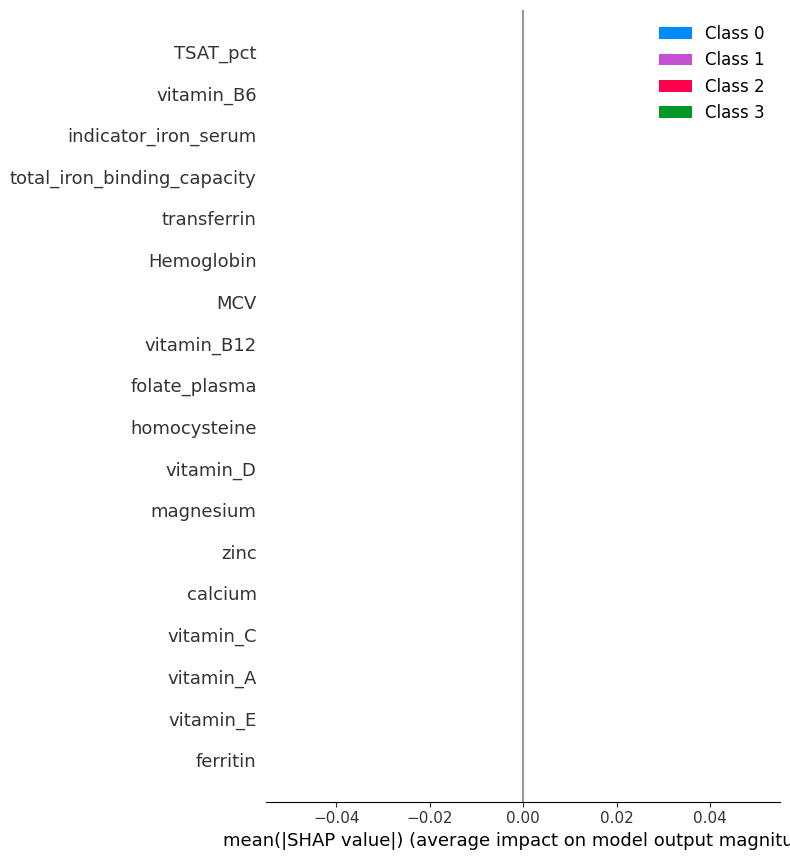

In [34]:
# --- SHAP explanations for interpretability ---
try:
    import shap
    explainer = shap.Explainer(clf)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test)
except ModuleNotFoundError:
    print("SHAP not installed. Run: pip install shap")
except Exception as e:
    print("SHAP explanation skipped:", e)


In [35]:
# --- Example prediction for one record ---

if len(X_test) > 0:
    i = 0
    proba = clf.predict_proba(X_test.iloc[[i]])
    pred = np.argmax(proba, axis=1)[0]

    print(f"Prediction for sample index {X_test.index[i]}:")
    print(f"Predicted class = {pred} | Probabilities = {proba.round(3).tolist()}")
    
    # Display top feature importances
    importances = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    print("\nTop contributing biomarkers:\n", importances.head(10))


Prediction for sample index 30:
Predicted class = 1 | Probabilities = [[0.003000000026077032, 0.996999979019165], [0.9990000128746033, 0.0010000000474974513], [0.9990000128746033, 0.0010000000474974513], [0.9990000128746033, 0.0010000000474974513]]

Top contributing biomarkers:
 ferritin                0.0
indicator_iron_serum    0.0
vitamin_B6              0.0
vitamin_E               0.0
vitamin_A               0.0
vitamin_C               0.0
calcium                 0.0
zinc                    0.0
magnesium               0.0
vitamin_D               0.0
dtype: float32
